# Demonstration of OVRO-LWA Stage 3 M&C

## Python APIs
1. ARX (Larry, Rick)
2. F-engine (Jack)
3. X-engine (Jack)
4. Data capture (Jayce)

## Setup

Set up scripts often run on lxdlwacr. lxdlwagpu03 is also ok.

Jack recommends:
1. Program and initialize SNAPs with lwa_snap_feng_init.py
2. Fire up the GPU pipelines with lwa352-start-pipeline.sh (possibly killing existing pipelines first)
3. Watch X-engine log files until things are running with names `<hostname>.<pipeline_id>.log`
4. Trigger correlator output with lwa352_arm_correlator.py
5. Currently, success means 10s integrations sent to lxdlwagpu03 for capture by Jayce's bifrost pipeline. Good logging:

`2021-07-08 20:33:17 [INFO    ] CORR OUTPUT >> Sending complete for time_tag 318652171392122880 in 2.12 seconds (381714432 Bytes; 1.44 Gb/s)`

Note: 
* F-engine "-t" flag injects test vector. 
* See also video recording of demo.


## Breakdown
1. lwa352-stop-pipeline.sh # essentially just a `killall lwa352-pipeline.py`

## Set up

In [1]:
%matplotlib inline

In [2]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Blues4
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd

output_notebook()

Loading BokehJS ...

In [3]:
cd ~/ovro_data_recorder/


/home/ubuntu/ovro_data_recorder


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from common import ETCD_HOST, ETCD_PORT  #  works in ovro_data_recorder directory

## etcd level M&C (low level)

In [5]:
import etcd3
le = etcd3.client(ETCD_HOST, ETCD_PORT)

# e.g., print a key:
# -- "le.get('/cmd/arx/2')"
# -- "le.get('/mon/snap/1')"

## ARX M&C

* Repo forthcoming "lwa-pyutils"
* This will be wrapped to refer to antenna, rather than ARX.
* Note that ARX come up with max attenuation (31.5)

In [6]:
from lwautils import lwa_arx
ma = lwa_arx.ARX()

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwautils/conf/etcdConfig.yml


In [61]:
adrs = [17,21,27,31]  # currently installed
for adr in adrs:
    ma.raw(adr, 'SETSC387')

In [62]:
ma.get_chan_cfg(adr, 0)

{'sig_on': True,
 'narrow_lpf': False,
 'narrow_hpf': False,
 'first_atten': 7.5,
 'second_atten': 15.0,
 'dc_on': True}

In [63]:
# setting custom config with dictionary

#ARX_CHAN_CFG = {}
#ARX_CHAN_CFG["dc_on"] = False
#ARX_CHAN_CFG["sig_on"] = False
#ARX_CHAN_CFG["narrow_lpf"] = True
#ARX_CHAN_CFG["narrow_hpf"] = False

#attenrange = list(range(58, 63))

#ARX_CHAN_CFG["first_atten"] = attenrange[0]*0.5
#ARX_CHAN_CFG["second_atten"] = attenrange[0]*0.5
#for chan in range(16):
#    ma.set_chan_cfg(27, chan, ARX_CHAN_CFG)

## F-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

In [64]:
from lwa_f import snap2_fengine
lwa_f = snap2_fengine.Snap2Fengine('snap01')

2021-07-19 22:26:19,039 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-07-19 22:26:19,494 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [65]:
for block in sorted(lwa_f.blocks.keys()):
    print(block)

adc
autocorr
corr
delay
eq
eqtvg
eth
fpga
input
noise
packetizer
pfb
powermon
reorder
sync


In [66]:
lwa_f.eqtvg.tvg_disable()

In [67]:
lwa_f.input.print_status()

mean00: -4.0187225341796875
mean01: 0.9747314453125
mean02: -1.833465576171875
mean03: -0.207916259765625
mean04: 1.9210662841796875
mean05: 1.7921905517578125
mean06: 0.13726806640625
mean07: 0.935302734375
mean08: -2.41290283203125
mean09: -0.9954833984375
mean10: 0.36517333984375
mean11: 0.323699951171875
mean12: -1.9294586181640625
mean13: 0.3371429443359375
mean14: -0.8711090087890625
mean15: -2.57470703125
mean16: -2.9656524658203125
mean17: -1.3236846923828125
mean18: 0.0345611572265625
mean19: 0.76654052734375
mean20: 0.8315582275390625
mean21: -1.1676788330078125
mean22: -0.0073089599609375
mean23: -0.715057373046875
mean24: -3.01043701171875
mean25: 1.2747802734375
mean26: 0.2182159423828125
mean27: 0.3885650634765625
mean28: -0.5336151123046875
mean29: -1.331573486328125
mean30: 2.045074462890625
mean31: -0.1029510498046875
mean32: -0.0108489990234375
mean33: 0.9051971435546875
mean34: -1.1084442138671875
mean35: -1.5575714111328125
mean36: -0.3509979248046875
mean37: -2.086

2021-07-19 22:26:19,688 - lwa_f.blocks.block:snap01 - INFO - input - Getting histogram for stream 0


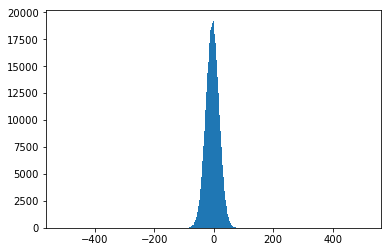

In [68]:
hist = lwa_f.input.plot_histogram(0)

In [69]:
specs = lwa_f.autocorr.get_new_spectra()   # before 4-bit scaling/quantization

In [70]:
len(specs), len(specs[0])

(16, 4096)

In [71]:
autospecs = []
for i in range(64):
    spec = lwa_f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
    autospecs.append(spec)

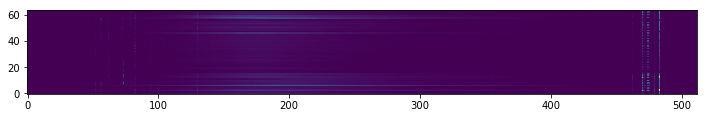

In [72]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
#for autospec in autospecs:
ax0.imshow(np.vstack(autospecs), origin='bottom')

In [73]:
#np.savez('spec_auto_4.npz', autospec)

In [74]:
#dd = {'x': list(range(512))}
#
#for i in range(64):
#    dd[str(i)] = autospecs[i]
#
#source = ColumnDataSource(dd)

In [77]:
TOOLTIPS = [
    ("Frequency channel", "$index"),
    ("Autocorrelation value", "$y"),
    ("SNAP2 autocorr", "$name"),
]

plot = figure(plot_width=950, plot_height=500, title='autocorr spectrum', tooltips=TOOLTIPS, tools='hover,wheel_zoom')
for i in range(64):
    _ = plot.line(x=dd['x'], y=autospecs[i], color='grey', name=str(i), hover_color='firebrick')
show(plot)

## X-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

"/mon/corr/xeng/<hostname>/pipeline/<pid>/corr" or "beamform"

In [86]:
from lwa352_pipeline_control import Lwa352PipelineControl
lwa_x = Lwa352PipelineControl(pipeline_id=0, etcdhost='10.42.0.64', host='lxdlwagpu02')

In [87]:
lwa_x.corr.get_bifrost_status()

{'pid': 31378,
 'name': 'Corr',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 5,
 'acquire': 6.818771362304688e-05,
 'process': 0.011490821838378906,
 'reserve': 1.2636184692382812e-05,
 'total': 0.011571645736694336,
 'gbps': 225.85204404893352,
 'time': 1626213225.1944742,
 'time_tag': 1,
 'sync_time': 0,
 'seq0': 38908387367040,
 'chan0': 576,
 'nchan': 192,
 'system_nchan': 3072,
 'fs_hz': 196000000,
 'sfreq': 13781250.0,
 'bw_hz': 4593750.0,
 'nstand': 352,
 'npol': 2,
 'complex': 'True',
 'nbit': 4,
 'acc_len': 2400,
 'stats': {'xgpu_acc_len': 480,
  'state': 'running',
  'update_pending': False,
  'last_cmd_proc_time': 1626211772.2429035,
  'start_time': 38908387367040,
  'acc_len': 2400,
  'curr_sample': 38908421890080,
  'new_start_

In [88]:
lwa_x.corr_acc.get_bifrost_status()

{'pid': 31378,
 'name': 'CorrAcc',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 6,
 'acquire': 0.08531641960144043,
 'process': 0.08074450492858887,
 'reserve': 0.00023055076599121094,
 'total': 0.1662914752960205,
 'gbps': 0.0,
 'time': 1626213228.203517,
 'time_tag': 1,
 'sync_time': 0,
 'seq0': 38908387703040,
 'chan0': 576,
 'nchan': 192,
 'system_nchan': 3072,
 'fs_hz': 196000000,
 'sfreq': 13781250.0,
 'bw_hz': 4593750.0,
 'nstand': 352,
 'npol': 2,
 'complex': 'True',
 'nbit': 4,
 'acc_len': 240000,
 'upstream_acc_len': 2400,
 'stats': {'state': 'running',
  'update_pending': False,
  'last_cmd_proc_time': 1626211786.2582088,
  'start_time': 38908387703040,
  'acc_len': 240000,
  'curr_sample': 38908421958240,
  'new_start_time': 389

In [89]:
from astropy import time
time.Time.now().unix

1626213231.258558

## Data capture M&C

In [91]:
import mcs #  works in ovro_data_recorder directory
from common import LWATime #  works in ovro_data_recorder directory

from datetime import timedelta, datetime

c = mcs.Client()
mcs_id = 'drvs19'   # data recorder visibilities slow server 19 (end of x-engine IP address)

In [92]:
# start
t_now = LWATime(datetime.utcnow() + timedelta(seconds=15), format='datetime', scale='utc')
mjd_now = int(t_now.mjd)
mpm_now = int((t_now.mjd - mjd_now)*86400.0*1000.0)
r = c.send_command(mcs_id, 'start', start_mjd=mjd_now, start_mpm=mpm_now)

In [93]:
# stop
r = c.send_command(mcs_id, 'stop', stop_mjd='now', stop_mpm=0)

In [94]:
r


(True,
 {'sequence_id': 'e0463440e42411ebbabd3cecef0c4411',
  'timestamp': 1626213259.7620645,
  'status': 'success',
  'response': {'filename': '/home/ubuntu/data'}})